# Bayesian decoding of neural activity

<div class="alert alert-block alert-info">

### ABOUT THIS LESSON 
---

Lesson time: 60 m   
Contributors: Federico Stella, Davide Spalla

**In this lesson you will learn:**
- What a bayesian decoder is and how to use it
- How to decode the position of an animal running in one and two dimensions
- How to use decoding techniques to investigate neural activity during sleep



## Introduction
---
 
In this lesson we will take a look at some techniques aimed at "reading" neural activity and allowing us to interpret its content and to evaluate how much information it carries about a specific set of stimuli, conditions or states. 



## Naive Bayes decoding
---
 Bayesian decoders are a simple but powerful tool for decoding the value of a stimulus from the observed neural activity.
 Let $P(s)$ denote the probability of presentation of stimulus $s$ (belonging to a set $S$) and $P(r|s)$ denote the conditional probability of obtaining a population response $r$ (out of a response set $R$) when stimulus s is presented. Using Bayes' theorem, we can write the probability of the stimulus given the response:

 $$P(s|r) = \frac{P(r|s)P(s)}{P(r)}$$

This equation gives the posterior probability that, given a response $r$, stimulus $s$ was presented. 
Bayesian decoding calculates from this posterior probability distribution a single prediction of the most likely stimulus, i.e. the maximum of the posterior distribution. 

In the case of a neural population, $P(r|s)$ lives in an $N$ dimensional space, where $N$ is the number of observed neuron, and its estimation can be a daunting problem. We can, however, make the simplifying assumption that the activity of each neuron is independent.In this case, we can factorize likelihood as:

$$P(r|s)=\prod_{i=1}^{N}P(r_{i}|s)$$

Note that, since we are generally interested in finding the maximum of the posterior distribtuion, we often do not need to evaluate the denominator $P(r)$ (which is usually difficult to calculate).
Moreover, if the prior $P(s)$ is flat (each stimulus value is equiprobable a priori), the problem simplifies further, and we are left with the follwing expression for the decoded stimulus value:

$$s^{*}=argmax_{s}(\prod_{i=1}^{N}P(r_{i}|s))$$

## more on poisson cell, log likelihood and final formula




### Decoding position on a linear track
---

As an example, let's look at how we can decode the position of the animal on a linear track from the activity of its hippocampal place cells. We will start from simulated data for a clearer example, then move on to some real data.
For the simulated data, well' use some generated with the code you can find in the lesson on [place cells]() of this course.

First, let's import the data:



In [74]:
import pickle
import numpy as np
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
from scipy.stats import pearsonr

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})

In [75]:
#code: data import
data_file = 'data/linear_track_data.pickle'
with open(data_file, 'rb') as handle:
    data = pickle.load(handle)

x,t,spikes = data['x'],data['t'],data['spikes']
track_length = data['track_length']
fps = data['fps'] 
n_cells = len(spikes)

Let's look at the data: we can plot the position as a funtion of time, and superimpose the points in which spikes are emitted by each cell.

In [76]:
def plot_unit(i):
    plt.plot(t, x)
    plt.plot(spikes[i], np.interp(spikes[i], t, x), 'r.')
    
interact(plot_unit, i = widgets.IntSlider(min=0, max=(n_cells-1), value=0))

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

<function __main__.plot_unit(i)>

<div class="alert alert-block alert-success"> 

### Interactive plotting with ipywidgets

In the cell above the use of [`interact`](https://ipywidgets.readthedocs.io/en/7.6.2/examples/Using%20Interact.html) (from [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/)) to make an interactive plot so that we quickly explore the behavior of all cells. `ipywidgets` offers quite a lot of methods to build simple interactive plot, and can be very useful to explore complex datasets.

As you can see, many cells have place-related activity (their firing concentrates around certain positions in the track). We can use the information provided by the neural population to decode the animals position, with our bayesian decoding framework.  
To perform bayesian decoding, we need to estimate $P(r_{i}|s)$. This is done by computiong the firing rate maps of each cell:

In [77]:
# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binnin in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)#np.vstack(spikes_hist).astype(np.float64)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy 

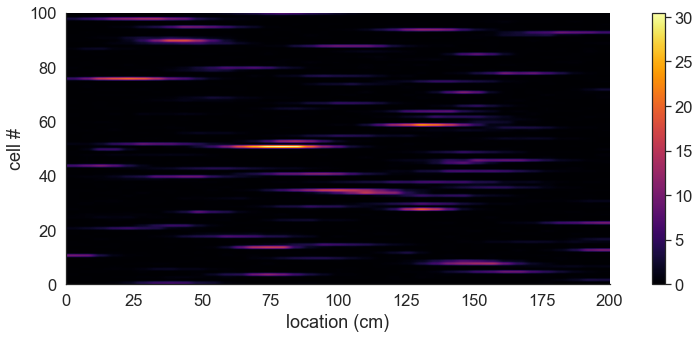

In [78]:
# let's look at the ratemaps
plt.figure(figsize=(15,5))
plt.imshow(firing_rate_maps, cmap='inferno', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')
plt.colorbar()

Next, we bin the spikes in 33 ms windows (the same temporal resolution of the behaviour)

In [79]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar samples x features shape

Now we can apply the equations we derived, to decode the position of the animal at each time

In [80]:
# code decoding
from scipy.stats import poisson

true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
decoding_times = t[:-1]

x_decoded = np.zeros_like(true_x)

for t_bin in tqdm(range(len(decoding_times))):
    if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes
        posterior = np.empty(firing_rate_maps.shape[-1])

        for i in range(len(posterior)):
            # Note that we work with log so that we can sum probabilities
            # instead of multiplying them 
            #posterior[i] = sum(np.log(poisson.pmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15)))
            posterior[i] = sum(poisson.logpmf(spikes_count[t_bin,:],firing_rate_maps[:,i]/fps)+pow(1,-15))


        x_decoded[t_bin] = space_bins[np.argmax(posterior)]
    else:
        x_decoded[t_bin] = np.nan   


100%|██████████| 5026/5026 [00:10<00:00, 477.42it/s]


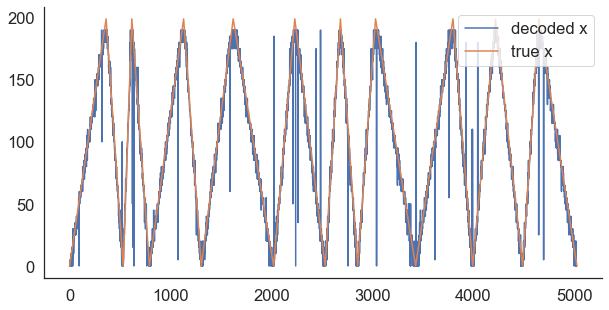

In [85]:
plt.figure(figsize=(10,5))
plt.plot(x_decoded,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

Median error: 3.357155002380459 cm


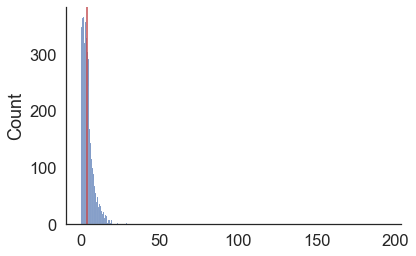

In [82]:
# error distribution
mse = np.sqrt((true_x-x_decoded)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')

Our decoder can predict the animal position with a median error around 6 cm. How do this changes with sample size, number of cell, and noise? You can explore the effect of these and other features in the [exercises](./exercises.ipynb)

<div class="alert alert-block alert-info">

### Vectorization of the bayes decoder
Above, we calculated the (log) posterior distributions by looping both on the time bins and the spatial bins.  
This results in a code that is quite slow, but we can do better: we can leverage the analytical expression of the posterior distirbution, and re-write the code using linear algebra, to obtain a much faster decoder.  

First, since the probability $P(n_{i}|x)$ of observing $n_{i}$ spikes from neuron $i$, given a position x, is assumed to be poissonian, we can write it as:

$$P(n_{i}|x) = \frac{(\tau f_{i}(x))^{n_{i}}}{n_{i}!}exp(-\tau f_{i}(x))$$

Where $f_{i}(x)$ is the average firing rate of the neuron in position $x$ (i.e. the firing rate map value).
For the whole population we then have:

$$P(n|x)=\prod_{i=1}^{N}P(n_{i}|x)= \prod_{i=1}^{N} \frac{(\tau f_{i}(x))^{n_{i}}}{n_{i}!}\exp(-\tau f_{i}(x)) $$

And this gives us the posterior:

$$P(x|n)=CP(x) \prod_{i=1}^{N} \frac{(\tau f_{i}(x))^{n_{i}}}{n_{i}!}\exp(-\tau f_{i}(x)) $$

Where $C$ is a normalization constant (that we do not need to calculate in our maximization procedure) and $P(x)$ is the positional prior.

Taking the logarithm of the posterior, we obtain:

$$\log(P(x|\textbf{n})))= \sum_{i=1}^{N} \left[ n_{i}\log(f_{i}(x)) -\tau f_{i}(x) \right]+\log(\tau) +\log(n!) + C + P(x)$$


We can rewritre the posterior calculation using the matrices $Sp$ (n_time_bins x n_space_bins), $Rm$ (n_cells,n_space_bins) and $Pr$ (1 x n_space_bins):

```
Pt = Sp @ np.log(Rm) - dt*np.sum(Rm, axis=0) + np.log(Pr)
```

With $dt=1/fps$.



In [86]:
#prior = occupancy / sum(occupancy)
epsilon = pow(1,-10)
log_posteriors = spikes_count @ np.log(firing_rate_maps+epsilon) - (1./fps)*np.sum(firing_rate_maps, axis=0) #+ np.log(prior + epsilon)

x_parallel = [space_bins[np.argmax(P)] for P in log_posteriors]

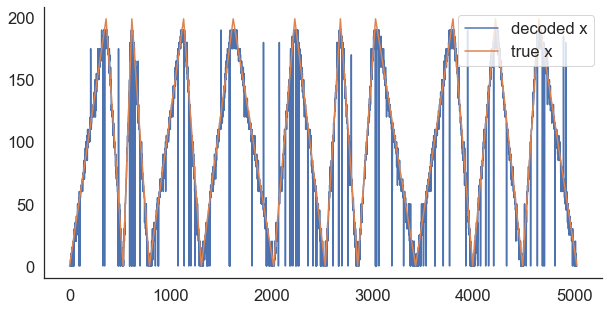

In [89]:
plt.figure(figsize=(10,5))
plt.plot(x_parallel,label= 'decoded x')
plt.plot(true_x,label = 'true x')
plt.legend()

Median error: 3.7851270758785205 cm


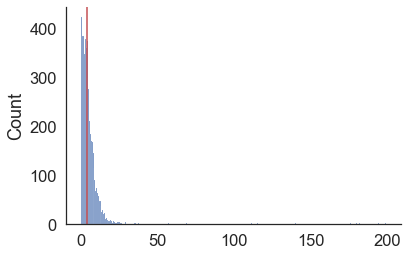

In [88]:
# error distribution
mse = np.sqrt((true_x-x_parallel)**2)
sns.histplot(mse)
plt.axvline(x = np.nanmedian(mse),c='r')
print(f'Median error: {np.nanmedian(mse)} cm')

As you can see, we obtain the same results (with some minor difference due to numerical effects), in a small fraction of the time.

<div class="alert alert-block alert-success"> 

### Timing function exectutions in pyhton
Python offers many tools to benchmark the execution time of your code.
Check out the %timeit [magic command](https://ipython.readthedocs.io/en/stable/interactive/magics.html) for jupyter, or this thread on stack oveflow on [measuring time of funtions](https://stackoverflow.com/questions/5478351/python-time-measure-function)

## Sequential reactivation during sleep
---

The use of decoding methods is not limited to measure the amount of information that a neural population carries about a specific set of stimuli, or to predict what stimulus is present at a given time. It is extremely useful to interpret the content of neural activity when no stimulus is present and such activity is spontaneously generated by the network and is not elicited by a specific stimulus. 


In the case of the hippocampus it has now been extensively observed that during rest periods (either while the animal is standing still, waiting somewhere, or while it is sleeping) place cells reactivate specific patterns of activity corresponding to sequences of locations in the environment. This phenomenon, called "replay" is thought to be critical for the formation of memory, for the acquisition of novel knowledge and for the reorganization of different sorts of information in the brain (You can read [this review](https://www.sciencedirect.com/science/article/abs/pii/S0166223610000172?via%3Dihub) for an overview on this vast and ebullient field of research).    


Here we want simulate the occurrence of such reactivation events. Some of them will actually contain sequences, that is, the neural activity will represents a series of locations in the order they appear on the linear track. Other reactivation events will instead contain activity representing locations of the linear track, but these locations will be randomly drawn, so they will present no clear ordering. 

In [24]:
# generate data 

n_events = 200 # number of reactivation events
event_duration = 100 # in bins
sampling_rate = 100 # sampling rate 
t_react = np.arange(0,100)
noise_x_react=5; # Noise in the reactivation of the sequence
noise_t_react=5; # Noise in the timing of the spikes 
noise_firing_rate = 0.1 # the baseline noise firing rate


reactivation_events = np.zeros((n_events,event_duration))
spikes_react = np.zeros((n_events,n_cells,event_duration))

for event in range(n_events):
    if(event<=n_events//2):
    #Generate "real" sequences for the first half of events
        x_start = np.random.uniform(0,track_length) # Starting point
        x_end = np.random.uniform(0,track_length) # Ending point
        x_react = np.linspace(x_start,x_end,event_duration) \
            +np.random.normal(0,noise_x_react,size=event_duration)

    else:
        #Pick locations randomly for the second half 
        x_react = np.random.uniform(0,track_length,size=event_duration);

    x_react[x_react<0]=0;
    x_react[x_react>track_length]=track_length
    
    #store reactivation sequence
    reactivation_events[event,:] = x_react

    
    # Generate spikes according to the location being reactivated in this event
    
    for i in range(n_cells):
        binned_x = np.digitize(x_react,bins=np.linspace(0,track_length,firing_rate_maps.shape[-1]))-1
        inst_rate = firing_rate_maps[i,binned_x] + np.random.normal(0,noise_firing_rate,size=len(binned_x))
        inst_rate[inst_rate<0] = 0
        spikes_loc = np.where(np.random.poisson(inst_rate/sampling_rate)>0)
        spikes_loc = spikes_loc + np.round(np.random.normal(0,noise_t_react,size=len(spikes_loc)))
        spikes_loc = spikes_loc[np.logical_and(spikes_loc>0,spikes_loc<event_duration)]
        spikes_react[event,i,spikes_loc.astype(int)] = 1
        
    


To visualize the sequence, we will plot the activity after sorting the cells according to the place field center (in this case defined as the peak location of their firing rate map).

Text(0, 0.5, 'cell #')

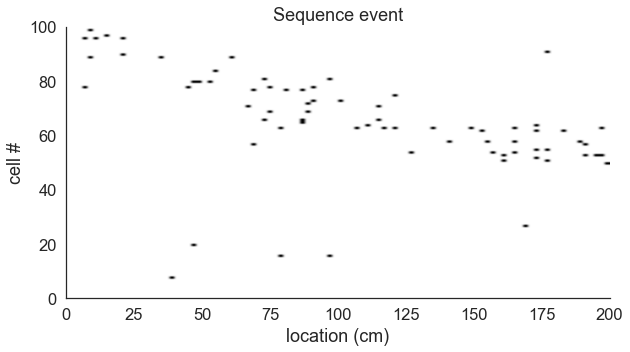

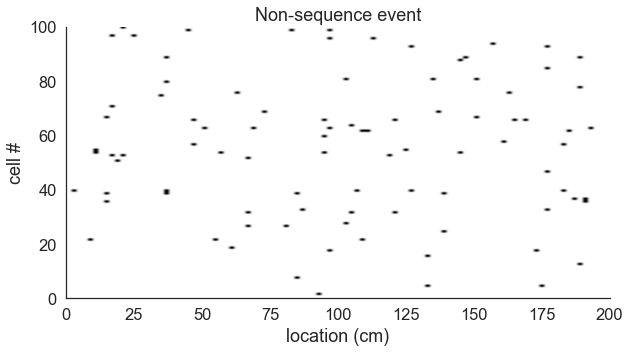

In [40]:
pfc_idxs = [np.argmax(rate_map) for rate_map in firing_rate_maps] 
sorted_idxs = np.argsort(pfc_idxs)


event = 50
plt.figure(figsize=(10,5))
plt.title('Sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')

event = 150
plt.figure(figsize=(10,5))
plt.title('Non-sequence event')
plt.imshow(spikes_react[event,sorted_idxs,:], cmap='Greys', extent = [0, 200, 0, n_cells])
plt.xlabel('location (cm)')
plt.ylabel('cell #')


We can now use bayesian decoding to detect reactivated sequences among these events.

In [46]:

time_window = 10 # number of bins to aggregate during decoding

reactivation_slope = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    # First we bin the events in windows of 10 bins
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//time_window))
    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//time_window):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*time_window :(t_r)*time_window],axis=1)

In [66]:
# to do: bayesian decoding
t_resize = 10 # We use spikes from multiple time windows for the decoding

reactivation_slopes = np.zeros(n_events)
reactivation_pvalues = np.zeros(n_events)

for event in range(n_events):

    event_spikes = spikes_react[event]
    spikes_sampled = np.zeros((n_cells,event_spikes.shape[1]//t_resize))

    # We generate a new spike matrix with the re-sized window
    for t_r in range(1,event_spikes.shape[1]//t_resize):
        spikes_sampled[:,t_r] = np.sum(event_spikes[:,(t_r-1)*t_resize :(t_r)*t_resize],axis=1)


    # We then perform decoding on the aggregated spikes
    x_decoded = np.zeros(spikes_sampled.shape[1])

    for t_bin in range(spikes_sampled.shape[1]):

        if sum(spikes_count[t_bin,:])>0: # Check if the time window contains spikes

            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = sum(poisson.logpmf(spikes_sampled[:,t_bin],firing_rate_maps[:,i]*t_resize/fps)+pow(1,-15))

            x_decoded[t_bin] = space_bins[np.argmax(posterior)]

        else:
            x_decoded[t_bin] = np.nan   

        # We fit a line to the decoded positions, and save the slope
        slope,_ = np.polyfit(np.arange(len(x_decoded)),x_decoded,deg=1)
        reactivation_slopes[event] = slope
        # And calculate the pvalue of the pearson correlation
        corr = pearsonr(np.arange(len(x_decoded)),x_decoded)
        reactivation_pvalues[event] = corr[1]


/Users/davide/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


<AxesSubplot:ylabel='Count'>

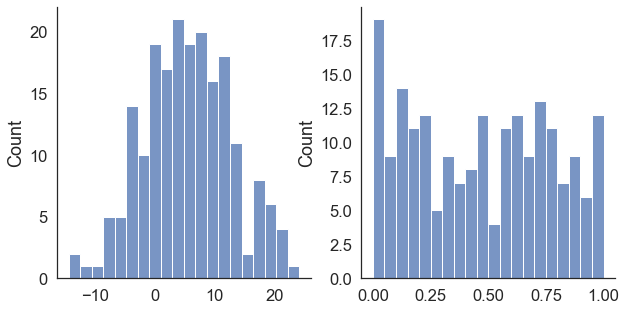

In [73]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(reactivation_slopes,bins=20)
plt.subplot(1,2,2)
sns.histplot(reactivation_pvalues,bins=20)


With this method we can detect a forward or backward sequence in our reactivation events. The calculation of the correlation p-value also allows us to assign a statistical confidence on how strongly the activity was sequentially organized.  



<div class="alert alert-block alert-info">

### Key points 

- Naive Bayes decoders use bayes' formula to estimate the probability of observing a stimulus given a certain pattern of neural responses
- In its simplest form, this algorithms relies on the assumption of *flat stimulus prior*, *and independence between neurons*
- This decoder can be used to recover the animal position during 1D and 2D navigation
- Decoding approaches can be used to investigate spontaneous neural activity during sleep or rest.

<div class="alert alert-block alert-info">

### References and resources

**Books & papers**
* Review on neural decoding: https://www.nature.com/articles/nrn2578
* Review on information processing in neural populations: https://www.nature.com/articles/35039062 
* Review on hippocampal replay and reactivation: https://www.sciencedirect.com/science/article/abs/pii/S0166223610000172?via%3Dihub 

**Websites & blogposts**

**Software**
* A python package for neural decoding: https://github.com/KordingLab/Neural_Decoding



## Exercises
You can find the exercises for this lessons in [exercises.ipynb](./exercises.ipynb)